# Load Data (already cleaned)

In [240]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None  # default='warn'

In [241]:
# read data in memory
train = pd.read_csv("C:\\Users\\Leo\\TaxiData\\clean_v2.csv",index_col=0)

E:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [242]:
test = pd.read_csv("C:\\Users\\Leo\\Dropbox\\Info Göttingen\\Practical Course Data Science\\Task 2\\data\\test_data_v2.csv",engine="python")

In [243]:
train.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,...,subtotal,tip_perc,pickup_hour,pickup_coord,dropoff_coord,avg_speed,holiday,overnight,day,ridesAtPickupHour
0,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,-73.977463,40.753979,2,...,7.3,0.000000,21,"(40.76093673706055, -73.98336029052734)","(40.75397872924805, -73.97746276855469)",7.255102,False,True,Thursday,20311.8
1,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,-73.981636,40.670242,1,...,23.3,0.171674,21,"(40.73666763305664, -73.98171997070312)","(40.67024230957031, -73.98163604736328)",10.957434,False,True,Thursday,20311.8
3,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,-73.929466,40.851540,1,...,27.3,0.036630,21,"(40.77389144897461, -73.98236083984375)","(40.851539611816406, -73.9294662475586)",14.996618,False,True,Thursday,20311.8
4,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,-73.985909,40.766445,1,...,14.8,0.200000,21,"(40.73317337036133, -73.98710632324219)","(40.7664451599121, -73.98590850830078)",11.082423,False,True,Thursday,20311.8
5,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,-73.993202,40.762642,1,...,11.8,0.200000,21,"(40.7394905090332, -73.99520111083984)","(40.76264190673828, -73.99320220947266)",10.211765,False,True,Thursday,20311.8


# Prepare the Test set (add features)

## Add duration in seconds

In [244]:
test["tpep_pickup_datetime"] = pd.to_datetime(test.tpep_pickup_datetime)
test['tpep_dropoff_datetime'] = pd.to_datetime(test.tpep_dropoff_datetime)

In [245]:
# Get duration
test['duration'] = pd.to_datetime(test["tpep_dropoff_datetime"])-pd.to_datetime(test["tpep_pickup_datetime"])

In [246]:
%%time
test["duration"] = test.apply(lambda x : x.duration.total_seconds(),axis=1)

Wall time: 3.33 s


## Calculate average speed

In [247]:
test = test.assign(avg_speed = test.trip_distance/test.duration*60*60)

In [248]:
test.avg_speed.describe()

count    64000.000000
mean        14.546904
std          9.388043
min          0.014337
25%          8.153310
50%         11.716077
75%         18.140034
max        176.170213
Name: avg_speed, dtype: float64

## Append Traffic data from train set

In [249]:
traffic = train.groupby(["day"])

In [250]:
trafficPerDay = pd.DataFrame()
for name, group in traffic:
    #group by hour
    pickupDate = group.tpep_pickup_datetime.str.split(" ").str[0];
    dates = pickupDate.unique()
    
    hours = group.groupby(["pickup_hour"]).trip_distance.count()
    
    trafficPerDay = trafficPerDay.append(pd.DataFrame({"day":name,"rides":hours/len(dates),"pickup_hour":hours.index},index=None))  
    print(name,dates,hours/len(dates))

Friday ['2016-06-10' '2016-06-03' '2016-06-17' '2016-06-24'] pickup_hour
0     14130.50
1      9091.50
2      5939.25
3      4051.25
4      3383.50
5      3798.50
6      8338.75
7     13974.25
8     17117.75
9     16000.00
10    14445.75
11    14557.75
12    15065.25
13    14747.50
14    15620.50
15    14060.50
16    12082.00
17    15336.50
18    18798.25
19    19513.25
20    17277.75
21    18387.50
22    19428.00
23    14896.50
Name: trip_distance, dtype: float64
Monday ['2016-06-06' '2016-06-13' '2016-06-20' '2016-06-27'] pickup_hour
0      7298.75
1      4589.50
2      3024.00
3      2056.50
4      2231.50
5      3438.75
6      8339.25
7     13192.25
8     15509.75
9     14803.50
10    13119.50
11    13179.50
12    13778.25
13    13839.50
14    15001.00
15    14391.00
16    13251.75
17    15776.75
18    18768.00
19    17767.00
20    16184.50
21    17819.50
22    15686.75
23     9583.50
Name: trip_distance, dtype: float64
Saturday ['2016-06-04' '2016-06-11' '2016-06-18' '2016-06-25']

In [251]:
test['pickup_hour'] = pd.to_datetime(test.tpep_pickup_datetime).dt.hour.astype('category')

In [252]:
test['day'] = (pd.to_datetime(test['tpep_pickup_datetime']).dt.weekday_name)

In [253]:
%%time
test["ridesAtPickupHour"] = test.apply(lambda x: trafficPerDay[(trafficPerDay.day == x.day) & (trafficPerDay.pickup_hour==x.pickup_hour)].rides.iloc[0],axis=1 )

Wall time: 47.2 s


## Remove some more outliers

In [254]:
t = train[train.avg_speed > 40]

In [255]:
t.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,duration,subtotal,tip_perc,pickup_hour,avg_speed,ridesAtPickupHour
count,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000,21435.000000
mean,1.655050,16.653108,-73.887584,40.707964,1.881969,-73.911413,40.719459,1.268300,51.418793,0.219827,0.435573,7.770273,3.517061,63.661527,1372.414836,55.891254,0.135355,7.130721,44.053253,8146.361887
std,1.311149,7.235212,0.096631,0.058282,1.094520,0.151482,0.089660,0.491032,28.728417,0.372911,0.167523,7.018051,4.773465,34.491467,579.544965,30.633138,0.108620,7.050564,4.354260,5255.996833
min,1.000000,0.370000,-74.913620,40.171890,1.000000,-74.984268,39.945095,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.300000,30.000000,3.300000,0.000000,0.000000,40.000000,1696.000000
25%,1.000000,13.340000,-73.981758,40.645973,1.000000,-73.987576,40.646820,1.000000,39.000000,0.000000,0.500000,0.000000,0.000000,43.800000,1099.000000,40.300000,0.000000,2.000000,41.267221,3332.400000
50%,1.000000,17.130000,-73.883774,40.718315,2.000000,-73.926231,40.708008,1.000000,52.000000,0.000000,0.500000,8.950000,0.000000,65.300000,1419.000000,56.300000,0.199691,5.000000,42.933516,6724.500000
75%,2.000000,19.310000,-73.783401,40.761063,2.000000,-73.788940,40.765629,1.000000,52.000000,0.500000,0.500000,11.670000,5.540000,70.010000,1617.000000,58.340000,0.200034,9.000000,45.439425,12539.500000
max,6.000000,99.960000,-73.212685,41.107155,5.000000,-73.017113,41.706463,4.000000,400.000000,4.500000,0.500000,128.000000,30.000000,483.340000,7755.000000,418.340000,3.703704,23.000000,80.000000,20311.800000


In [256]:
t.RatecodeID.value_counts()

1    9475
2    8346
3    1730
5    1447
4     437
Name: RatecodeID, dtype: int64

In [257]:
train.RatecodeID.value_counts()

1    8907479
2     127432
3      17425
5      11165
4       3539
Name: RatecodeID, dtype: int64

In [258]:
train = train[(train.avg_speed<=60)]

In [259]:
train.shape

(9066771, 27)

In [260]:
test.describe()

,id,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,tolls_amount,improvement_surcharge,duration,avg_speed,ridesAtPickupHour
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.00000,64000.000000,64000.000000,64000.000000,64000.000000
mean,32000.500000,1.537047,1.671188,5.896713,-73.960769,40.744481,1.406250,-73.975568,40.746855,1.337031,1.74787,0.299991,1230.515344,14.546904,14415.856201
std,18475.352951,0.498630,1.303686,7.234262,0.060701,0.037676,0.913769,0.084823,0.047903,0.492926,4.14628,0.001677,1080.955692,9.388043,3799.740583
min,1.000000,1.000000,0.000000,0.010000,-74.527763,40.535580,1.000000,-74.833679,40.045311,1.000000,0.00000,0.000000,40.000000,0.014337,1696.000000
25%,16000.750000,1.000000,1.000000,1.200000,-73.991264,40.732536,1.000000,-73.993828,40.725780,1.000000,0.00000,0.300000,468.000000,8.153310,13251.750000
50%,32000.500000,2.000000,1.000000,2.260000,-73.980370,40.752197,1.000000,-73.980309,40.751484,1.000000,0.00000,0.300000,858.000000,11.716077,14940.000000
75%,48000.250000,2.000000,2.000000,8.080000,-73.962111,40.766815,1.000000,-73.960541,40.768697,2.000000,0.00000,0.300000,1659.000000,18.140034,16814.500000
max,64000.000000,2.000000,9.000000,86.600000,-72.659561,41.255787,5.000000,-72.551582,41.525589,4.000000,82.50000,0.300000,9931.000000,176.170213,20311.800000


## Function for parameter optimization for lightGBM

In [302]:
#optimization parameters for lightGBM
param_grid = {    
    'num_leaves':[7,31,150,500,1000],
    #"max_depth":[-1,10,30,51],
    'learning_rate': [0.003],  
    "objective": ["mae"],
    "bagging_fraction" : [0.8], 
    "feature_fraction" : [0.8], 
    "num_threads" : [4],
    "verbose":[-1],
    "boosting":["gbdt"], #rf does not work
}



In [303]:
from sklearn.model_selection import ParameterGrid
from operator import itemgetter
import lightgbm as lgb
import timeit
import copy

def optimisedLGM(param_grid,trainData,labels,stopping=50):
    lgb_dataset = lgb.Dataset(trainData, label=labels)
    
    cv_results = []
    counter = 0
    print("Total parameter combinations to run:",len(ParameterGrid(param_grid)))
    first_param = None;
    for params in ParameterGrid(param_grid):
        start_time = timeit.default_timer()
        counter=counter+1
        print("Starting run",counter)
        print(params)
        validation_summary = lgb.cv(params,
                                    lgb_dataset,
                                    num_boost_round=10000, 
                                    nfold=3,
                                    early_stopping_rounds=stopping,
                                    verbose_eval=100,
                                    stratified=False)

        params["optimal_number_of_trees"] = len(validation_summary["l1-mean"])
        if(first_param == None):
            first_param=copy.deepcopy(params)
        cv_results.append((params, validation_summary["l1-mean"][-1]))    
        #this currently is buggy. the first element of the results will always be overriden by the last
        
        elapsed = timeit.default_timer() - start_time
        if (counter %1 == 0):
            print("Run done, took:",round(elapsed,2),"s")   

    first_tuple = cv_results[0]
    first_param
    cv_results[0] = (first_param,first_tuple[1]) # this fixes the bug mentioned above, no idea why this is happening though
    param_set = min(cv_results,key=itemgetter(1)) #best params, minimal mae
    print("Best params:",param_set)
    #print(cv_results)   
    lgb_model = lgb.train(param_set[0],lgb_dataset,param_set[0]["optimal_number_of_trees"])
    return lgb_model

In [263]:
from sklearn.model_selection import ParameterGrid
from operator import itemgetter
import lightgbm as lgb
import timeit
from sklearn.model_selection import GridSearchCV

def optimisedLGM2(param_grid,trainData,labels):

    estimator = lgb.LGBMRegressor(objective = "mae",n_jobs=2)
    param_grid = {
        'learning_rate': [0.05],
        'n_estimators': [200,400,600,800],
        'num_leaves':[7,80],
        "boosting_type":["gbdt"],
        "max_depth":[2,63,None],    
    }

    gbm = GridSearchCV(estimator,param_grid,verbose=2,n_jobs=2)    

    gbm.fit(trainData,labels)
    print('Best parameters found by grid search are:', gbm.best_params_)
    print("Best score:",gbm.cv_results_)
    return gbm;

# Ratecode 1 (Standard rate)

## Building the Model

In [264]:
code1data = train[train.RatecodeID == 1]

In [265]:
code1test = test[test.RatecodeID == 1]

In [267]:
test.columns

Index(['id', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'tolls_amount',
       'improvement_surcharge', 'duration', 'avg_speed', 'pickup_hour', 'day',
       'ridesAtPickupHour'],
      dtype='object')

In [274]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour"]
#train new model
#code1_model = optimisedLGM(param_grid,code1data[features],code1data["fare_amount"])

#use old params
params = ({'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 1000, 'num_threads': 4, 'objective': 'mae', 'verbose': -1, 'optimal_number_of_trees': 10000})
code1_dataset = lgb.Dataset(code1data[features], label=code1data["fare_amount"])
code1_model = lgb.train(params,code1_dataset,params["optimal_number_of_trees"])

Wall time: 1h 11min 12s


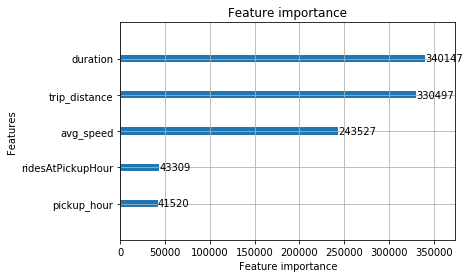

In [272]:
lgb.plot_importance(code1_model, max_num_features=10)

## Prediction

In [172]:
code1prediction = np.round(code1_model.predict(code1test[features])*2)/2

In [173]:
code1prediction

array([ 4. ,  6.5, 10.5, ...,  4.5,  6. , 15. ])

In [174]:
code1test = code1test.assign(fare_amount_prediction = code1prediction)

# Ratecode 2 (JFK)

## Building the Model

No model building neccessary, all rides cost 52$

In [175]:
code2data = train[train.RatecodeID == 2]
code2test = test[test.RatecodeID == 2]

## Prediction

In [176]:
code2test["fare_amount_prediction"] = 52.0

# Ratecode 3 (Newark)

## Building the Model

In [337]:
code3data = train[train.RatecodeID == 3]

In [338]:
code3test = test[test.RatecodeID == 3]

In [339]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour"]
code3_model = optimisedLGM(param_grid,code3data[features],code3data["fare_amount"]-20)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 6.32118 + 0.0898515
[200]	cv_agg's l1: 5.40236 + 0.0864623
[300]	cv_agg's l1: 4.70288 + 0.0851631
[400]	cv_agg's l1: 4.13374 + 0.0931556
[500]	cv_agg's l1: 3.65932 + 0.0830107
[600]	cv_agg's l1: 3.26608 + 0.0768116
[700]	cv_agg's l1: 2.94976 + 0.0755124
[800]	cv_agg's l1: 2.68184 + 0.0713168
[900]	cv_agg's l1: 2.44556 + 0.0654861
[1000]	cv_agg's l1: 2.24491 + 0.0598136
[1100]	cv_agg's l1: 2.03455 + 0.0574693
[1200]	cv_agg's l1: 1.76629 + 0.0478241
[1300]	cv_agg's l1: 1.53938 + 0.0341861
[1400]	cv_agg's l1: 1.36948 + 0.0256537
[1500]	cv_agg's l1: 1.23755 + 0.0152891
[1600]	cv_agg's l1: 1.14492 + 0.0124463
[1700]	cv_agg's l1: 1.07562 + 0.0117453
[1800]	cv_agg's l1: 1.02571 + 0.011244
[1900]	cv_agg's l1: 0.988005 + 0.0113142
[2000]	cv_agg's l1: 0.960461 +

[9000]	cv_agg's l1: 0.780241 + 0.00643898
[9100]	cv_agg's l1: 0.780179 + 0.00645239
[9200]	cv_agg's l1: 0.780117 + 0.00646624
[9300]	cv_agg's l1: 0.780069 + 0.00648258
[9400]	cv_agg's l1: 0.78003 + 0.00650132
[9500]	cv_agg's l1: 0.779977 + 0.00649629
[9600]	cv_agg's l1: 0.779907 + 0.00652489
[9700]	cv_agg's l1: 0.779879 + 0.00655474
[9800]	cv_agg's l1: 0.779817 + 0.00651437
Run done, took: 22.1 s
Starting run 3
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 150, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 5.98777 + 0.0801301
[200]	cv_agg's l1: 4.81673 + 0.0853936
[300]	cv_agg's l1: 3.9269 + 0.0822157
[400]	cv_agg's l1: 3.24834 + 0.0786918
[500]	cv_agg's l1: 2.72237 + 0.0742806
[600]	cv_agg's l1: 2.31075 + 0.0651006
[700]	cv_agg's l1: 1.98672 + 0.0549708
[800]	cv_agg's l1: 1.71895 + 0.0415745
[900]	cv_agg's l1: 1.46382 + 0.0301264
[1000]	cv_agg's l1: 1.26991 + 0.017163
[1100]	cv_agg's l1: 1.1361 + 

## Prediction

In [180]:
code3prediction = np.round(code3_model.predict(code3test[features])*2)/2+20
code3test = code3test.assign(fare_amount_prediction = code3prediction)

# Ratecode 4 (Nassau or Westchester)

## Building the Model

In [181]:
code4data = train[train.RatecodeID == 4]
code4test = test[test.RatecodeID == 4]
np.shape(code4test)

(1000, 20)

In [182]:
#shapely can be installed via anaconda -> environments
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [183]:
# returns whether the point given is in the area given
def inArea(polygon,lat,long):
    point = Point(lat,long);
    poly = Polygon(polygon)
    return poly.contains(point)    

In [184]:
#cords for a polygon around manhatten, manually set via google maps
manhattan_cords = [(40.882207, -73.933869), #1
         (40.872343, -73.908292), #2
         (40.836117, -73.933011), #3
         (40.804680, -73.931123), #4
         (40.798833, -73.918591), #5
         (40.739289, -73.967000), #6
         (40.707155, -73.973866), #7
         (40.699217, -74.021416), #8
         (40.759316, -74.012662)] #9

In [185]:
#apply to train set
code4data["endsInManhattan"] = code4data.apply(lambda x : inArea(manhattan_cords,x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)
code4data["startsInManhattan"] = code4data.apply(lambda x : inArea(manhattan_cords,x["pickup_latitude"],x["pickup_longitude"]),axis=1)

In [186]:
from geopy.distance import geodesic
from geopy.distance import great_circle

In [187]:
#calculate air line distance for train data set
code4data["airlineDistance"] = code4data.apply(lambda x: geodesic((x["pickup_latitude"],x["pickup_longitude"]),
                                                                  (x["dropoff_latitude"],x["dropoff_longitude"])).miles,axis=1)

In [188]:
code4data.airlineDistance.describe()

count    3537.000000
mean        9.832166
std         5.325333
min         0.012965
25%         5.279775
50%         9.870849
75%        13.463199
max        27.942278
Name: airlineDistance, dtype: float64

In [189]:
np.shape(code4data[["airlineDistance","trip_distance"]])

(3537, 2)

In [190]:
np.shape(code4data[code4data.trip_distance<code4data.airlineDistance])

(45, 30)

In [191]:
code4data = code4data[code4data.trip_distance >= code4data.airlineDistance]

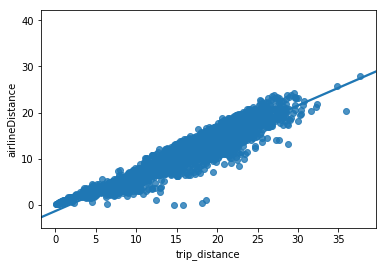

In [192]:
ax = sns.regplot(code4data.trip_distance,code4data.airlineDistance)
ax.plot([0,0],[40,40], linewidth=2,color="red")

In [193]:
# all bridges and tunnels to/from manhattan, bridges marked with ! are highways or tunnels and more likely to be used by taxis
bridges = [ (40.877720, -73.922362), # 0 henry hudson bridge !
          (40.873648, -73.911075), # 1 broadway !
          (40.862840, -73.914986), # 2 university heights bridge
          (40.846674, -73.927806), # 3 washington bridge - close to v
          (40.845522, -73.928256), # 4 alexander hamilton bridge !
          (40.828062, -73.933873), # 5 macombs dam bridge
          (40.819489, -73.933058), # 6 145th st bridge - close to v
          (40.814081, -73.933187), # 7 madison avenue bridge
          (40.807591, -73.932399), # 8 third avenue bridge
           (40.803516, -73.928818),# 9 willis ave bridge
           (40.800368, -73.927835), # 10 robert f kennedy bridge !
           (40.756681, -73.954185), # 11 ed koch queensboro bridge !
           (40.745106, -73.964063), # 12 queens midtown tunnel !
           (40.713407, -73.972299), # 13 williamsburg bridge
           (40.707095, -73.990500), # 14 manhattan bridge
           (40.705972, -73.996851), # 15 brooklyn bridge !
           (40.701161, -74.015692), # 16 Hugh l Carey Tunnel
           (40.727487, -74.020880), # 17 holland tunnel
           (40.763370, -74.010028), # 18 lincoln tunnel !
           (40.851644, -73.952118), # 19 george washington bridge !
          ]

In [194]:
# try to find out which bridge is used in a trip 
# assumption: the bridge is used that minimizes the pickup-bridge-dropoff distance (air-line distance)
counter = 1
for index, row in code4data.iterrows():
    # 4 options:
    # starts in city, ends in city --> should not have ratecode 4 -> outlier, ignore
    # starts in city, ends out of city -> standard trip
    # starts out of city, ends out of city -> no calculations to be done here, use double rate for whole trip
    # starts out of city, ends in city -> reverse standard trip
    startP = (row["pickup_latitude"],row["pickup_longitude"])
    endP = (row["dropoff_latitude"],row["dropoff_longitude"])
    
    if(row.startsInManhattan and row.endsInManhattan):
        #print("Outlier found, index",index)
        continue
    elif (not row.startsInManhattan and not row.endsInManhattan):
        #print("Complete out of city trip, index",index)
        code4data.at[index,"Bridge"] = None;
        code4data.at[index,"in_city_distance"] = 0;
        code4data.at[index,"out_of_city_distance"] = geodesic(startP, endP).miles
        code4data.at[index,"total_over_bridge_distance"] = geodesic(startP, endP).miles  
        continue
    elif (not row.startsInManhattan and  row.endsInManhattan): # reverse trip
        temp = startP # here we swap start and endpoints so its similar to a standard trip
        startP = endP
        endP = temp
    
    #find closest bridge
    closest_bridge_index = -1
    closest_total_bridge_distance = float('inf')
    for i in range(len(bridges)):
        distance_to_bridge = geodesic(startP, bridges[i]).miles
        distance_to_dest =  geodesic(bridges[i],endP).miles
        total = distance_to_bridge + distance_to_dest
        if(total < closest_total_bridge_distance):
            closest_total_bridge_distance = total
            closest_bridge_index = i
            closest_distance_to_bridge = distance_to_bridge
            closest_distance_to_dest = distance_to_dest
            
    #print("Route {} travels over bridge/tunnel {} (to bridge: {:0.2f}, to dest: {:0.2f}, total: {:0.2f}, trip_distance : {:0.2f})".format(
    #    counter, closest_bridge_index,closest_distance_to_bridge,closest_distance_to_dest,closest_total_bridge_distance,totalDistance))
    counter = counter + 1
    
    code4data.at[index,"Bridge"] = closest_bridge_index;
    code4data.at[index,"in_city_distance"] = closest_distance_to_bridge;
    code4data.at[index,"out_of_city_distance"] = closest_distance_to_dest
    code4data.at[index,"total_over_bridge_distance"] = closest_total_bridge_distance       

In [195]:
#states how much of the fare was contributed by ride in the city. Calculated by 
code4data["inCityPercentage"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+2*x.out_of_city_distance+0.0001),axis=1)

In [196]:
#2.5 were subtracted from fare amount (inital charge)
code4data["inCityFare"] = code4data.apply(lambda x: x.inCityPercentage*(x.fare_amount-2.5),axis=1)
code4data["outCityFare"] = code4data.apply(lambda x: (1-x.inCityPercentage)*(x.fare_amount-2.5),axis=1)

In [197]:
code4data["inCityTripDistanceExtreme"] = code4data.apply(lambda x: x.inCityPercentage*x.trip_distance,axis=1)
code4data["outCityTripDistanceExtreme"] = code4data.apply(lambda x: (1-x.inCityPercentage)*x.trip_distance,axis=1)

In [198]:
code4data["inCityTripDistance"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)
code4data["outCityTripDistance"] = code4data.apply(lambda x: x.out_of_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [276]:
code4data["in_city_ratio"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

Now we have to train three models. Two for trips that start in the city and end out of it and vice versa, thus using both the standard and the doubled rate (one model for each). The predctions are then add up. The third model is for trips that are completly out of the city and therefore only use the doubled rate. Here more information can be used from the dataset, because we do not have to make assumptions on where the trip was split.

In [278]:
code4data_mixed = code4data[code4data.startsInManhattan ^ code4data.endsInManhattan] # trips that used a bridge -> entered/left manhattan
np.shape(code4data_mixed)

(596, 42)

In [279]:
code4data_out = code4data[(code4data.startsInManhattan==False) & (code4data.endsInManhattan==False)] # trips that not used a bridge -> never were in Manhattan
np.shape(code4data_out)

(2758, 42)

In [280]:
%%time
#chose features
features_inner = ["inCityTripDistance","trip_distance","duration","ridesAtPickupHour","avg_speed","in_city_ratio"]
features_outer = ["outCityTripDistance","trip_distance","duration","ridesAtPickupHour","avg_speed","in_city_ratio"]

mixed_inner_train = code4data_mixed[features_inner]
mixed_outer_train = code4data_mixed[features_outer]

code4_model_inner = optimisedLGM(param_grid,mixed_inner_train,code4data_mixed["inCityFare"])

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 4.891 + 0.259278
[200]	cv_agg's l1: 4.07164 + 0.242305
[300]	cv_agg's l1: 3.50568 + 0.236206
[400]	cv_agg's l1: 3.05597 + 0.222082
[500]	cv_agg's l1: 2.69626 + 0.195879
[600]	cv_agg's l1: 2.3847 + 0.15365
[700]	cv_agg's l1: 2.13219 + 0.114635
[800]	cv_agg's l1: 1.93488 + 0.0999967
[900]	cv_agg's l1: 1.79709 + 0.0994246
[1000]	cv_agg's l1: 1.68273 + 0.10063
[1100]	cv_agg's l1: 1.59036 + 0.101241
[1200]	cv_agg's l1: 1.51679 + 0.0896025
[1300]	cv_agg's l1: 1.4638 + 0.0889147
[1400]	cv_agg's l1: 1.42331 + 0.0920581
[1500]	cv_agg's l1: 1.38614 + 0.0916568
[1600]	cv_agg's l1: 1.3551 + 0.0896759
[1700]	cv_agg's l1: 1.33239 + 0.0870955
[1800]	cv_agg's l1: 1.31116 + 0.0808271
[1900]	cv_agg's l1: 1.29607 + 0.0781515
[2000]	cv_agg's l1: 1.28444 + 0.0761906
[2100]

[5800]	cv_agg's l1: 1.16838 + 0.0553154
[5900]	cv_agg's l1: 1.16762 + 0.0555632
[6000]	cv_agg's l1: 1.16709 + 0.0557589
[6100]	cv_agg's l1: 1.16648 + 0.055743
[6200]	cv_agg's l1: 1.16632 + 0.0558931
Run done, took: 3.68 s
Starting run 4
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 500, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 4.86148 + 0.247034
[200]	cv_agg's l1: 3.98249 + 0.23296
[300]	cv_agg's l1: 3.36697 + 0.232136
[400]	cv_agg's l1: 2.87156 + 0.212864
[500]	cv_agg's l1: 2.4881 + 0.185166
[600]	cv_agg's l1: 2.19843 + 0.153443
[700]	cv_agg's l1: 1.97844 + 0.136434
[800]	cv_agg's l1: 1.81498 + 0.135139
[900]	cv_agg's l1: 1.67361 + 0.126505
[1000]	cv_agg's l1: 1.5693 + 0.117545
[1100]	cv_agg's l1: 1.4921 + 0.104582
[1200]	cv_agg's l1: 1.429 + 0.101398
[1300]	cv_agg's l1: 1.38002 + 0.0981514
[1400]	cv_agg's l1: 1.34593 + 0.0945841
[1500]	cv_agg's l1: 1.32088 + 0.090862
[1600]	cv_agg's l1: 1.30

In [282]:
%%time
code4_model_outer = optimisedLGM(param_grid,mixed_outer_train,code4data_mixed["outCityFare"])

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 14.0106 + 0.984749
[200]	cv_agg's l1: 11.7275 + 0.906427
[300]	cv_agg's l1: 10.033 + 0.879684
[400]	cv_agg's l1: 8.74971 + 0.862571
[500]	cv_agg's l1: 7.7609 + 0.835354
[600]	cv_agg's l1: 6.98217 + 0.787081
[700]	cv_agg's l1: 6.34629 + 0.708181
[800]	cv_agg's l1: 5.85722 + 0.60479
[900]	cv_agg's l1: 5.51421 + 0.529009
[1000]	cv_agg's l1: 5.28332 + 0.48642
[1100]	cv_agg's l1: 5.10394 + 0.438689
[1200]	cv_agg's l1: 4.97975 + 0.407261
[1300]	cv_agg's l1: 4.89062 + 0.388471
[1400]	cv_agg's l1: 4.82708 + 0.378446
[1500]	cv_agg's l1: 4.78757 + 0.372917
[1600]	cv_agg's l1: 4.76035 + 0.367136
[1700]	cv_agg's l1: 4.74175 + 0.366885
[1800]	cv_agg's l1: 4.72748 + 0.370062
[1900]	cv_agg's l1: 4.7134 + 0.371211
[2000]	cv_agg's l1: 4.7004 + 0.374893
[2100]	cv_agg's 

In [281]:
%%time
features_combined = ["inCityTripDistance","outCityTripDistance","in_city_ratio","duration","trip_distance","ridesAtPickupHour","avg_speed"]
code4_model_combined = optimisedLGM(param_grid,code4data_mixed[features_combined],code4data_mixed["fare_amount"]-2.5)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 13.1354 + 1.12335
[200]	cv_agg's l1: 11.0816 + 1.11477
[300]	cv_agg's l1: 9.60493 + 1.03347
[400]	cv_agg's l1: 8.55511 + 0.968291
[500]	cv_agg's l1: 7.68469 + 0.878239
[600]	cv_agg's l1: 6.98617 + 0.79855
[700]	cv_agg's l1: 6.54392 + 0.722276
[800]	cv_agg's l1: 6.2029 + 0.634812
[900]	cv_agg's l1: 5.98804 + 0.574592
[1000]	cv_agg's l1: 5.83899 + 0.55316
[1100]	cv_agg's l1: 5.7366 + 0.541957
[1200]	cv_agg's l1: 5.65801 + 0.526099
[1300]	cv_agg's l1: 5.60512 + 0.505436
[1400]	cv_agg's l1: 5.55874 + 0.490612
[1500]	cv_agg's l1: 5.51934 + 0.474476
[1600]	cv_agg's l1: 5.49098 + 0.461708
[1700]	cv_agg's l1: 5.46886 + 0.454425
[1800]	cv_agg's l1: 5.45279 + 0.45412
[1900]	cv_agg's l1: 5.43794 + 0.452868
[2000]	cv_agg's l1: 5.42686 + 0.450918
[2100]	cv_agg's l1

Wall time: 12.7 s


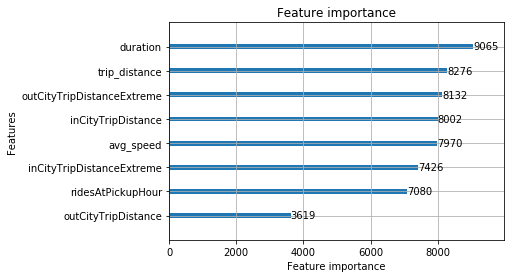

In [204]:
lgb.plot_importance(code4_model_combined, max_num_features=10)

In [205]:
features_all = ["trip_distance","duration","avg_speed","ridesAtPickupHour"]
code4_model_all = optimisedLGM(param_grid,code4data[features_all],code4data["fare_amount"]-2.5)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 15.0686 + 0.0906655
[200]	cv_agg's l1: 12.2194 + 0.0527201
[300]	cv_agg's l1: 10.2269 + 0.0554988
[400]	cv_agg's l1: 8.84895 + 0.11779
[500]	cv_agg's l1: 7.9354 + 0.168896
[600]	cv_agg's l1: 7.29728 + 0.208083
[700]	cv_agg's l1: 6.85168 + 0.251711
[800]	cv_agg's l1: 6.5426 + 0.279921
[900]	cv_agg's l1: 6.30254 + 0.294187
[1000]	cv_agg's l1: 6.09516 + 0.303513
[1100]	cv_agg's l1: 5.93149 + 0.308394
[1200]	cv_agg's l1: 5.81001 + 0.310498
[1300]	cv_agg's l1: 5.73107 + 0.313099
[1400]	cv_agg's l1: 5.67801 + 0.312802
[1500]	cv_agg's l1: 5.64474 + 0.312821
[1600]	cv_agg's l1: 5.62024 + 0.310727
[1700]	cv_agg's l1: 5.60543 + 0.310083
[1800]	cv_agg's l1: 5.59422 + 0.311428
[1900]	cv_agg's l1: 5.58658 + 0.312092
[2000]	cv_agg's l1: 5.58139 + 0.310997
[2100]	cv_

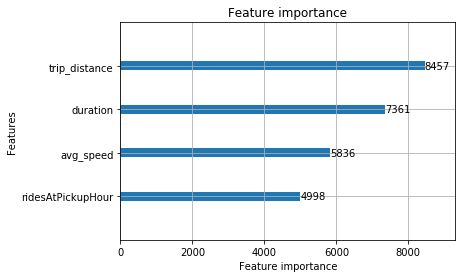

In [206]:
lgb.plot_importance(code4_model_all, max_num_features=10)

Next: model for outer trips.


In [335]:
%%time
# make train set
features = ["trip_distance","duration","ridesAtPickupHour","avg_speed"]

code4_model_out = optimisedLGM(param_grid,code4data_out[features],code4data_out["fare_amount"]-2.5)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 14.4566 + 0.0864501
[200]	cv_agg's l1: 11.6216 + 0.0879369
[300]	cv_agg's l1: 9.64401 + 0.0709149
[400]	cv_agg's l1: 8.29257 + 0.0868636
[500]	cv_agg's l1: 7.41124 + 0.104273
[600]	cv_agg's l1: 6.81342 + 0.0948956
[700]	cv_agg's l1: 6.41299 + 0.0943908
[800]	cv_agg's l1: 6.13642 + 0.101701
[900]	cv_agg's l1: 5.94414 + 0.11052
[1000]	cv_agg's l1: 5.7983 + 0.111509
[1100]	cv_agg's l1: 5.69884 + 0.119421
[1200]	cv_agg's l1: 5.62309 + 0.118308
[1300]	cv_agg's l1: 5.56791 + 0.11988
[1400]	cv_agg's l1: 5.53038 + 0.123284
[1500]	cv_agg's l1: 5.50515 + 0.122582
[1600]	cv_agg's l1: 5.48781 + 0.124614
[1700]	cv_agg's l1: 5.47382 + 0.124747
[1800]	cv_agg's l1: 5.46504 + 0.125807
[1900]	cv_agg's l1: 5.45948 + 0.128025
[2000]	cv_agg's l1: 5.45652 + 0.127253
[2100]	

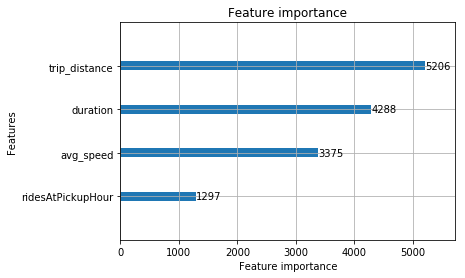

In [336]:
lgb.plot_importance(code4_model_out, max_num_features=10)

## Prediction

In [209]:
#apply to test set
code4test["endsInManhattan"] = code4test.apply(lambda x : inArea(manhattan_cords,x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)
code4test["startsInManhattan"] = code4test.apply(lambda x : inArea(manhattan_cords,x["pickup_latitude"],x["pickup_longitude"]),axis=1)

We have four possible trip patterns:
    1. starts in city, ends in city --> should not have ratecode 4 -> outlier, ignore
    2. starts in city, ends out of city -> standard trip
    3. starts out of city, ends out of city -> no calculations to be done here, use double rate for whole trip
    4. starts out of city, ends in city -> reverse standard trip

In [210]:
np.shape(code4test)

(1000, 22)

In [211]:
#option1: trips that start and end in manhattan, these should not have this ratecode
code4test_wrong = code4test[(code4test.startsInManhattan & code4test.endsInManhattan)]
np.shape(code4test_wrong)

(35, 22)

In [212]:
#option2 & option 4: 
code4test_mixed = code4test[code4test.startsInManhattan ^ code4test.endsInManhattan] 
np.shape(code4test_mixed)

(238, 22)

In [213]:
#option 3:
code4test_out = code4test[(code4test.startsInManhattan==False) & (code4test.endsInManhattan==False)] 
np.shape(code4test_out)

(727, 22)

In [214]:
# try to find out which bridge is used in a trip 
# assumption: the bridge is used that minimizes the pickup-bridge-dropoff distance (air-line distance)
counter = 1
for index, row in code4test_mixed.iterrows():
    
    startP = (row["pickup_latitude"],row["pickup_longitude"])
    endP = (row["dropoff_latitude"],row["dropoff_longitude"])
    
    if(row.startsInManhattan and row.endsInManhattan):
        #print("Outlier found, index",index)
        continue
    elif (not row.startsInManhattan and not row.endsInManhattan):
        #print("Complete out of city trip, index",index)
        code4test_mixed.at[index,"bridge"] = None;
        code4test_mixed.at[index,"in_city_distance"] = 0;
        code4test_mixed.at[index,"out_of_city_distance"] = geodesic(startP, endP).miles
        code4test_mixed.at[index,"total_over_bridge_distance"] = geodesic(startP, endP).miles  
        continue
    elif (not row.startsInManhattan and  row.endsInManhattan): # reverse trip
        temp = startP # here we swap start and endpoints so its similar to a standard trip
        startP = endP
        endP = temp
    
    #find closest bridge
    closest_bridge_index = -1
    closest_total_bridge_distance = float('inf')
    for i in range(len(bridges)):
        distance_to_bridge = geodesic(startP, bridges[i]).miles
        distance_to_dest =  geodesic(bridges[i],endP).miles
        total = distance_to_bridge + distance_to_dest
        if(total < closest_total_bridge_distance):
            closest_total_bridge_distance = total
            closest_bridge_index = i
            closest_distance_to_bridge = distance_to_bridge
            closest_distance_to_dest = distance_to_dest
            
    #print("Route {} travels over bridge/tunnel {} (to bridge: {:0.2f}, to dest: {:0.2f}, total: {:0.2f}, trip_distance : {:0.2f})".format(
    #    counter, closest_bridge_index,closest_distance_to_bridge,closest_distance_to_dest,closest_total_bridge_distance,totalDistance))
    counter = counter + 1
    
    code4test_mixed.at[index,"bridge"] = closest_bridge_index;
    code4test_mixed.at[index,"in_city_distance"] = closest_distance_to_bridge;
    code4test_mixed.at[index,"out_of_city_distance"] = closest_distance_to_dest
    code4test_mixed.at[index,"total_over_bridge_distance"] = closest_total_bridge_distance       

In [215]:
#states how much of the fare was contributed by ride in the city. Calculated by 
code4test_mixed["inCityPercentage"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+2*x.out_of_city_distance+0.0001),axis=1)

In [216]:
code4test_mixed["inCityTripDistance"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)
code4test_mixed["outCityTripDistance"] = code4test_mixed.apply(lambda x: x.out_of_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [217]:
code4test_mixed["inCityTripDistanceExtreme"] = code4test_mixed.apply(lambda x: x.inCityPercentage*x.trip_distance,axis=1)
code4test_mixed["outCityTripDistanceExtreme"] = code4test_mixed.apply(lambda x: (1-x.inCityPercentage)*x.trip_distance,axis=1)

In [ ]:
code4test_mixed["in_city_ratio"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [218]:
# prediction for the inner city part
code4_mixed_inner_pred = code4_model_inner.predict(code4test_mixed[features_inner])

In [219]:
#prediction for out of city part
code4_mixed_outer_pred = code4_model_outer.predict(code4test_mixed[features_outer])

In [220]:
code4_mixed_combined_pred = code4_model_combined.predict(code4test_mixed[features_combined])

In [221]:
#combine the results
#round comined predictions to closest .5
#add 2.5 inital charge which was removed before training
code4test_mixed["fare_amount_prediction"]=np.round((code4_mixed_inner_pred+code4_mixed_outer_pred)*2)/2+2.5

In [222]:
code4test_mixed["fare_amount_prediction"].describe()

count    238.000000
mean      70.735294
std       19.754380
min       16.000000
25%       58.000000
50%       69.500000
75%       92.375000
max      106.500000
Name: fare_amount_prediction, dtype: float64

In [223]:
code4test_mixed["fare_amount_prediction"]=np.round(code4_mixed_combined_pred*2)/2+2.5

In [224]:
code4test_mixed["fare_amount_prediction"].describe()

count    238.000000
mean      70.705882
std       19.479992
min       16.000000
25%       59.500000
50%       68.750000
75%       92.125000
max      100.000000
Name: fare_amount_prediction, dtype: float64

Next: predict out trips.

In [225]:
code4test_out_pred = code4_model_out.predict(code4test_out[features])
code4test_out["fare_amount_prediction"]=np.round(code4test_out_pred*2)/2+2.5

Lastly: predict trips that only were in Manhattan with double rate model (same as outer trips)

In [226]:
code4_test_wrong_pred = code4_model_out.predict(code4test_wrong[features])
code4test_wrong["fare_amount_prediction"]=np.round(code4_test_wrong_pred*2)/2+2.5

In [227]:
#combine all code 4 dataframes with predictions
code4test = pd.concat([code4test_mixed,code4test_out,code4test_wrong])

# Ratecode 5 (Negotiated Fares)

## Building the Model

In [307]:
code5data = train[train.RatecodeID == 5]
code5data = code5data.assign(fare_to_distance_ratio = code5data.fare_amount/code5data.trip_distance)
code5data = code5data[(code5data.fare_to_distance_ratio<20) & (code5data.fare_to_distance_ratio>=1)]
code5test = test[test.RatecodeID == 5]


In [313]:
code5data.tolls_amount.describe()

count    9945.000000
mean        7.598675
std         6.660595
min         0.000000
25%         0.000000
50%        10.500000
75%        12.500000
max        30.000000
Name: tolls_amount, dtype: float64

In [308]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(code5data.day)

LabelEncoder()

In [309]:
list(le.classes_)

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [310]:
code5data["day_int"] = le.transform(code5data.day)

In [311]:
code5data["weekend"] = code5data.apply(lambda x: ((x.day == "Sunday") | (x.day=="Saturday")) and 1 or 0,axis=1)

In [316]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour","tolls_amount"]

code5_model = optimisedLGM(param_grid,code5data[features],code5data["fare_amount"]-2.5)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 27.6406 + 0.352742
[200]	cv_agg's l1: 23.9965 + 0.345063
[300]	cv_agg's l1: 21.6757 + 0.344191
[400]	cv_agg's l1: 20.067 + 0.267053
[500]	cv_agg's l1: 18.9201 + 0.226732
[600]	cv_agg's l1: 18.1458 + 0.197412
[700]	cv_agg's l1: 17.5926 + 0.166741
[800]	cv_agg's l1: 17.2087 + 0.170112
[900]	cv_agg's l1: 16.9178 + 0.150652
[1000]	cv_agg's l1: 16.7189 + 0.139975
[1100]	cv_agg's l1: 16.5634 + 0.12648
[1200]	cv_agg's l1: 16.4448 + 0.114219
[1300]	cv_agg's l1: 16.3618 + 0.107027
[1400]	cv_agg's l1: 16.3078 + 0.105792
[1500]	cv_agg's l1: 16.2673 + 0.104247
[1600]	cv_agg's l1: 16.2332 + 0.102902
[1700]	cv_agg's l1: 16.2092 + 0.103914
[1800]	cv_agg's l1: 16.1879 + 0.106337
[1900]	cv_agg's l1: 16.1654 + 0.111037
[2000]	cv_agg's l1: 16.1515 + 0.113472
[2100]	cv_ag

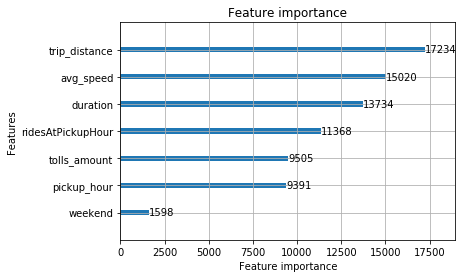

In [315]:
lgb.plot_importance(code5_model, max_num_features=10)

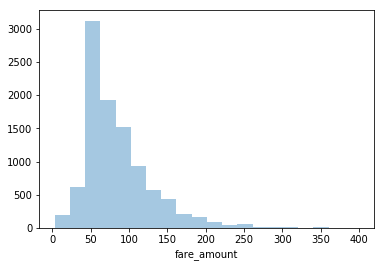

In [317]:
ax = sns.distplot(code5data.fare_amount,kde=False,bins=20);

In [318]:
code5data.fare_amount.value_counts()

50.00     909
60.00     772
45.00     636
80.00     507
100.00    445
70.00     421
120.00    326
40.00     324
55.00     313
65.00     313
75.00     287
90.00     277
85.00     249
150.00    201
110.00    179
130.00    128
52.00     126
95.00     122
125.00     88
140.00     88
200.00     77
30.00      73
35.00      73
160.00     66
115.00     65
88.00      63
135.00     56
105.00     55
76.00      54
20.00      42
         ... 
275.00      1
288.88      1
287.00      1
236.50      1
40.25       1
85.25       1
68.34       1
66.66       1
99.50       1
149.75      1
89.30       1
170.50      1
79.70       1
47.67       1
19.50       1
14.20       1
125.55      1
113.78      1
129.70      1
216.00      1
354.00      1
22.50       1
28.50       1
283.00      1
114.50      1
80.50       1
40.34       1
145.54      1
169.50      1
79.20       1
Name: fare_amount, Length: 562, dtype: int64

In [326]:
code5data.shape

(9945, 30)

In [329]:
t = code5data[code5data.fare_amount%0.5 != 0][["trip_distance","duration","fare_amount"]]

In [330]:
t["fare_to_distance_ratio"]= t.fare_amount/t.trip_distance

In [331]:
t.fare_to_distance_ratio.describe()

count    335.000000
mean       6.369723
std        3.056824
min        1.406725
25%        4.354730
50%        5.403309
75%        7.703981
max       19.461538
Name: fare_to_distance_ratio, dtype: float64

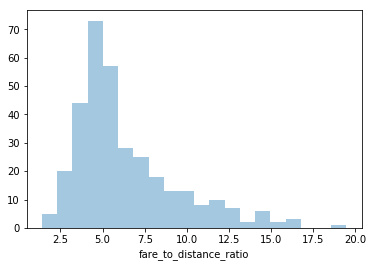

In [332]:
ax = sns.distplot(t.fare_to_distance_ratio,kde=False,bins=20);

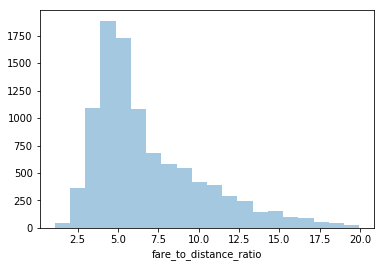

In [334]:
ax = sns.distplot(code5data.fare_to_distance_ratio,kde=False,bins=20);

## Prediction

In [230]:
code5prediction = code5_model.predict(code5test[features])
code5test = code5test.assign(fare_amount_prediction = code5prediction)

# Recombine all predictions and save

In [231]:
testResult = pd.concat([code1test,code2test,code3test,code4test,code5test])

In [232]:
testResult.to_csv("C:\\Users\\Leo\\Dropbox\\Info Göttingen\\Practical Course Data Science\\Task 2\\data\\test_prediction.csv")

In [233]:
testResult.fare_amount_prediction.describe()

count    64000.000000
mean        22.726293
std         23.373723
min          3.000000
25%          7.500000
50%         12.000000
75%         30.500000
max        251.509255
Name: fare_amount_prediction, dtype: float64

In [234]:
testResult.describe()

,RatecodeID,VendorID,avg_speed,bridge,dropoff_latitude,dropoff_longitude,duration,fare_amount_prediction,id,improvement_surcharge,...,outCityTripDistanceExtreme,out_of_city_distance,passenger_count,payment_type,pickup_latitude,pickup_longitude,ridesAtPickupHour,tolls_amount,total_over_bridge_distance,trip_distance
count,64000.000000,64000.000000,64000.000000,238.00000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,...,238.000000,238.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.00000,238.000000,64000.000000
mean,1.406250,1.537047,14.546904,9.89916,40.746855,-73.975568,1230.515344,22.726293,32000.500000,0.299991,...,18.743958,12.461605,1.671188,1.337031,40.744481,-73.960769,14415.856201,1.74787,16.208426,5.896713
std,0.913769,0.498630,9.388043,4.81803,0.047903,0.084823,1080.955692,23.373723,18475.352951,0.001677,...,9.182369,6.509709,1.303686,0.492926,0.037676,0.060701,3799.740583,4.14628,6.321360,7.234262
min,1.000000,1.000000,0.014337,0.00000,40.045311,-74.833679,40.000000,3.000000,1.000000,0.000000,...,1.658264,0.662656,0.000000,1.000000,40.535580,-74.527763,1696.000000,0.00000,1.763670,0.010000
25%,1.000000,1.000000,8.153310,7.00000,40.725780,-73.993828,468.000000,7.500000,16000.750000,0.300000,...,12.923967,8.278194,1.000000,1.000000,40.732536,-73.991264,13251.750000,0.00000,12.896369,1.200000
50%,1.000000,2.000000,11.716077,10.00000,40.751484,-73.980309,858.000000,12.000000,32000.500000,0.300000,...,17.606952,11.964156,1.000000,1.000000,40.752197,-73.980370,14940.000000,0.00000,15.435084,2.260000
75%,1.000000,2.000000,18.140034,12.00000,40.768697,-73.960541,1659.000000,30.500000,48000.250000,0.300000,...,23.086686,15.545136,2.000000,2.000000,40.766815,-73.962111,16814.500000,0.00000,18.683674,8.080000
max,5.000000,2.000000,176.170213,19.00000,41.525589,-72.551582,9931.000000,251.509255,64000.000000,0.300000,...,59.300306,37.757120,9.000000,4.000000,41.255787,-72.659561,20311.800000,82.50000,39.327866,86.600000


In [235]:
testResult[testResult.fare_amount_prediction == testResult.fare_amount_prediction.max()]

,RatecodeID,VendorID,avg_speed,bridge,day,dropoff_latitude,dropoff_longitude,duration,endsInManhattan,fare_amount_prediction,...,pickup_latitude,pickup_longitude,ridesAtPickupHour,startsInManhattan,store_and_fwd_flag,tolls_amount,total_over_bridge_distance,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
62740,5,2,53.284661,NaN,Friday,40.847366,-72.551582,5561.0,NaN,251.509255,...,40.746029,-73.974525,19513.25,NaN,N,5.54,NaN,2016-05-27 20:51:57,2016-05-27 19:19:16,82.31


In [236]:
testResult[testResult.trip_distance == testResult.trip_distance.max()]

,RatecodeID,VendorID,avg_speed,bridge,day,dropoff_latitude,dropoff_longitude,duration,endsInManhattan,fare_amount_prediction,...,pickup_latitude,pickup_longitude,ridesAtPickupHour,startsInManhattan,store_and_fwd_flag,tolls_amount,total_over_bridge_distance,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
62191,5,1,40.577899,NaN,Saturday,41.460213,-73.235245,7683.0,NaN,246.06927,...,40.643486,-73.789948,16038.5,NaN,N,7.62,NaN,2016-05-21 16:49:42,2016-05-21 14:41:39,86.6


In [237]:
testResult.RatecodeID.value_counts()

1    50000
2     7000
3     4000
5     2000
4     1000
Name: RatecodeID, dtype: int64

# Archive

### Ratecode 1

### Ratecode 4